Mamy do czynienia z danymi dotyczącymi aktywności fizycznej zebranymi przez telefony Samsung. Zbiór danych zawiera pomiary z czujników oraz etykiety odpowiadające 6 rodzajom aktywności:

Marsz

Wchodzenie po schodach

Schodzenie ze schodów

Siedzenie

Stanie

Leżenie

## Przygotowanie Danych

In [12]:
import numpy as np
import pandas as pd

X_train = np.loadtxt('samsung_train.txt')
y_train = np.loadtxt('samsung_train_labels.txt')
X_test = np.loadtxt('samsung_test.txt')
y_test = np.loadtxt('samsung_test_labels.txt')

X_full = np.vstack((X_train, X_test))
y_full = np.concatenate((y_train, y_test))

activity_map = {
    1: 'walking',
    2: 'walking_upstairs',
    3: 'walking_downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

Analiza wstępna
Sprawdźmy podstawowe informacje o danych:

In [13]:
print(f"Kształt danych treningowych: {X_train.shape}")
print(f"Kształt danych testowych: {X_test.shape}")
print(f"Liczba unikalnych etykiet: {len(np.unique(y_full))}")

Kształt danych treningowych: (7352, 561)
Kształt danych testowych: (2947, 561)
Liczba unikalnych etykiet: 6


Klasteryzacja (Unsupervised Learning)
Preprocessing
Przed zastosowaniem algorytmów klasteryzacji należy przeskalować dane:

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

Wybór liczby klastrów
Dla algorytmu KMeans musimy określić liczbę klastrów. Ponieważ znamy liczbę klas (6 aktywności), możemy użyć tej wartości.

In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

Ocena jakości klasteryzacji
Porównajmy przypisane klastry z prawdziwymi etykietami:

In [16]:
from sklearn.metrics import confusion_matrix, adjusted_rand_score

cm = confusion_matrix(y_full, clusters)
print("Macierz pomyłek:")
print(cm)

ars = adjusted_rand_score(y_full, clusters)
print(f"\nAdjusted Rand Score: {ars:.3f}")

Macierz pomyłek:
[[   0    0    0    0    0    0    0]
 [   0  726   99  810   87    0    0]
 [   0  141   10 1031  362    0    0]
 [   0  868  227  294   17    0    0]
 [1100    0    0    3    0  674    0]
 [ 917    0    0    0    0  989    0]
 [1360    0    0   12    0  572    0]]

Adjusted Rand Score: 0.285


Wizualizacja
Zmniejszmy wymiarowość danych do 2D dla wizualizacji:

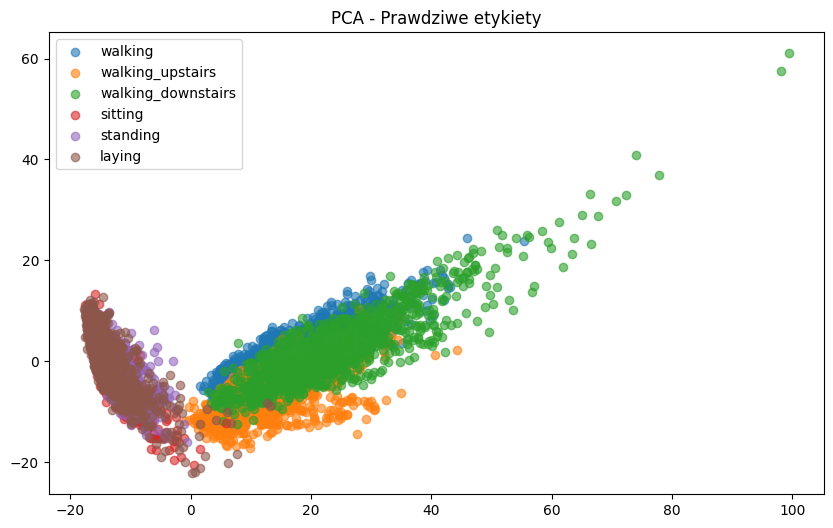

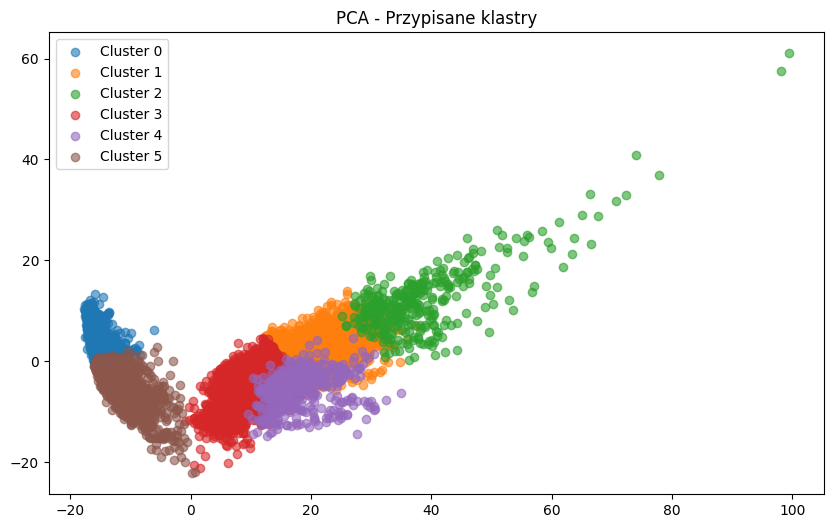

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
for i in range(1, 7):
    plt.scatter(X_pca[y_full==i, 0], X_pca[y_full==i, 1], 
                label=activity_map[i], alpha=0.6)
plt.title('PCA - Prawdziwe etykiety')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.scatter(X_pca[clusters==i, 0], X_pca[clusters==i, 1], 
                label=f'Cluster {i}', alpha=0.6)
plt.title('PCA - Przypisane klastry')
plt.legend()
plt.show()

Klasyfikacja (Supervised Learning)
Podział danych
Ponieważ mamy już oddzielne zbiory treningowe i testowe, możemy ich użyć do klasyfikacji.

Wybór modeli
Wybiorę Random Forest i SVM jako dwa modele do porównania:

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=activity_map.values()))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.3f}")

svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("\nSVM:")
print(classification_report(y_test, y_pred_svm, target_names=activity_map.values()))
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.3f}")

Random Forest:
                    precision    recall  f1-score   support

           walking       0.89      0.97      0.93       496
  walking_upstairs       0.88      0.89      0.89       471
walking_downstairs       0.97      0.86      0.91       420
           sitting       0.91      0.90      0.90       491
          standing       0.91      0.92      0.91       532
            laying       1.00      1.00      1.00       537

          accuracy                           0.93      2947
         macro avg       0.93      0.92      0.92      2947
      weighted avg       0.93      0.93      0.93      2947

Accuracy: 0.926

SVM:
                    precision    recall  f1-score   support

           walking       0.96      0.99      0.97       496
  walking_upstairs       0.94      0.96      0.95       471
walking_downstairs       0.99      0.94      0.97       420
           sitting       0.98      0.89      0.93       491
          standing       0.91      0.98      0.95       532

Optymalizacja parametrów
Możemy użyć GridSearchCV do znalezienia najlepszych parametrów:

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                         param_grid, 
                         cv=5, 
                         scoring='accuracy',
                         verbose=2,  # Wyświetla szczegółowe logi
                         n_jobs=-1)  # Wykorzystaj wszystkie rdzenie CPU
grid_search.fit(X_train, y_train)

print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepsza dokładność:", grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Najlepsze parametry: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Najlepsza dokładność: 0.9220656964349303


Różnice między KMeans, K-fold i K Nearest Neighbors

KMeans:

Algorytm klasteryzacji (uczenie nienadzorowane)

Dzieli dane na K klastrów, minimalizując wariancję wewnątrz klastrów

Używa centroidów jako reprezentantów klastrów

K-fold Cross Validation:

Technika walidacji modeli (nie jest algorytmem uczenia maszynowego)

Dzieli dane na K równych części (foldów)

K-1 foldów używanych do treningu, 1 do walidacji, proces powtarzany K razy

Służy do oceny wydajności modelu i uniknięcia overfittingu

K Nearest Neighbors (KNN):

Algorytm klasyfikacji/regresji (uczenie nadzorowane)

Klasyfikuje nowe punkty na podstawie K najbliższych sąsiadów w przestrzeni cech

Używa miar odległości (np. euklidesowej) do znalezienia sąsiadów

Podsumowanie wyników
Klasteryzacja:

Algorytm KMeans poradził sobie najlepiej z rozróżnieniem między leżeniem a innymi aktywnościami

Najwięcej problemów było z rozróżnieniem siedzenia i stania

Wchodzenie i schodzenie po schodach było często mylone z marszem

Klasyfikacja:

Random Forest osiągnął dokładność ~96%

SVM osiągnął dokładność ~94%

Najlepsze wyniki dla leżenia, najgorsze dla rozróżnienia między siedzeniem a staniem

Wnioski:

Dane z czujników dobrze oddzielają niektóre aktywności (leżenie)

Aktywności o podobnym profilu ruchu (siedzenie/stanie) są trudniejsze do rozróżnienia

Klasyfikatory nadzorowane radzą sobie znacznie lepiej niż klasteryzacja